# Introduction to DataFrames
**[Bogumił Kamiński](http://bogumilkaminski.pl/about/), February 13, 2023**

In [1]:
using DataFrames

In [2]:
using CategoricalArrays

## Extras - selected functionalities of selected packages

In [3]:
using FreqTables

In [4]:
df = DataFrame(a=rand('a':'d', 1000), b=rand(["x", "y", "z"], 1000))
ft = freqtable(df, :a, :b) # observe that dimensions are sorted if possible

4×3 Named Matrix{Int64}
a ╲ b │  x   y   z
──────┼───────────
'a'   │ 72  94  88
'b'   │ 76  91  69
'c'   │ 78  74  88
'd'   │ 97  85  88

In [5]:
ft[1,1], ft['b', "z"] # you can index the result using numbers or names

(72, 69)

In [6]:
prop(ft, margins=1) # getting proportions - 1 means we want to calculate them in rows (first dimension)

4×3 Named Matrix{Float64}
a ╲ b │        x         y         z
──────┼─────────────────────────────
'a'   │ 0.283465  0.370079  0.346457
'b'   │ 0.322034  0.385593  0.292373
'c'   │    0.325  0.308333  0.366667
'd'   │ 0.359259  0.314815  0.325926

In [7]:
prop(ft, margins=2) # and columns are normalized to 1.0 now

4×3 Named Matrix{Float64}
a ╲ b │        x         y         z
──────┼─────────────────────────────
'a'   │  0.22291  0.273256  0.264264
'b'   │ 0.235294  0.264535  0.207207
'c'   │ 0.241486  0.215116  0.264264
'd'   │  0.30031  0.247093  0.264264

In [8]:
x = categorical(rand(1:3, 10))
levels!(x, [3, 1, 2, 4]) # reordering levels and adding an extra level
freqtable(x) # order is preserved and not-used level is shown

4-element Named Vector{Int64}
Dim1  │ 
──────┼──
3     │ 2
1     │ 4
2     │ 4
4     │ 0

In [9]:
freqtable([1,1,2,3,missing]) # by default missings are listed

4-element Named Vector{Int64}
Dim1    │ 
────────┼──
1       │ 2
2       │ 1
3       │ 1
missing │ 1

In [10]:
freqtable([1,1,2,3,missing], skipmissing=true) # but we can skip them

3-element Named Vector{Int64}
Dim1  │ 
──────┼──
1     │ 2
2     │ 1
3     │ 1

In [11]:
df = DataFrame(a=rand(3:4, 1000), b=rand(5:6, 1000))
ft = freqtable(df, :a, :b) # now dimensions are numbers

2×2 Named Matrix{Int64}
a ╲ b │   5    6
──────┼─────────
3     │ 227  256
4     │ 263  254

In [12]:
ft[3,5] # this is an error - standard array indexing takes precedence

LoadError: BoundsError: attempt to access 2×2 Matrix{Int64} at index [3, 5]

In [13]:
ft[Name(3), Name(5)] # you have to use Name() wrapper

227

### DataFramesMeta.jl - working on `DataFrame`

DataFramesMeta.jl provides a more terse syntax due to the benefits of metaprogramming.

In [14]:
using DataFramesMeta

In [15]:
df = DataFrame(x=1:8, y='a':'h', z=repeat([true,false], outer=4))

Row,x,y,z
,Int64,Char,Bool
1,1,a,true
2,2,b,false
3,3,c,true
4,4,d,false
5,5,e,true
6,6,f,false
7,7,g,true
8,8,h,false


In [16]:
@with(df, :x + :z) # expressions with columns of DataFrame

8-element Vector{Int64}:
 2
 2
 4
 4
 6
 6
 8
 8

In [17]:
@with df begin # you can define code blocks
    a = :x[:z]
    b = :x[.!:z]
    :y + [a; b]
end

8-element Vector{Char}:
 'b': ASCII/Unicode U+0062 (category Ll: Letter, lowercase)
 'e': ASCII/Unicode U+0065 (category Ll: Letter, lowercase)
 'h': ASCII/Unicode U+0068 (category Ll: Letter, lowercase)
 'k': ASCII/Unicode U+006B (category Ll: Letter, lowercase)
 'g': ASCII/Unicode U+0067 (category Ll: Letter, lowercase)
 'j': ASCII/Unicode U+006A (category Ll: Letter, lowercase)
 'm': ASCII/Unicode U+006D (category Ll: Letter, lowercase)
 'p': ASCII/Unicode U+0070 (category Ll: Letter, lowercase)

In [18]:
a # @with creates hard scope so variables do not leak out

LoadError: UndefVarError: `a` not defined

In [19]:
df2 = DataFrame(a = [:a, :b, :c])
@with(df2, :a .== ^(:a)) # sometimes we want to work on a raw Symbol, ^() escapes it

3-element BitVector:
 1
 0
 0

In [20]:
x_str = "x"
y_str = "y"
df2 = DataFrame(x=1:3, y=4:6, z=7:9)
# $expression inderpolates the expression in-place; in particular this way you can use column names passed as strings
@with(df2, $x_str + $y_str)

3-element Vector{Int64}:
 5
 7
 9

In [21]:
@subset(df, :x .< 4, :z .== true) # a very useful macro for filtering

Row,x,y,z
,Int64,Char,Bool
1,1,a,true
2,3,c,true


In [22]:
@select(df, :x, :y = 2*:x, :z=:y) # create a new DataFrame based on the old one

Row,x,y,z
,Int64,Int64,Char
1,1,2,a
2,2,4,b
3,3,6,c
4,4,8,d
5,5,10,e
6,6,12,f
7,7,14,g
8,8,16,h


In [23]:
@transform(df, :x = 2*:x, :y = :x) # create a new DataFrame adding columns based on the old one

Row,x,y,z
,Int64,Int64,Bool
1,2,1,true
2,4,2,false
3,6,3,true
4,8,4,false
5,10,5,true
6,12,6,false
7,14,7,true
8,16,8,false


In [24]:
@orderby(df, :z, -:x) # sorting into a new data frame, less powerful than sort, but lightweight

Row,x,y,z
,Int64,Char,Bool
1,8,h,false
2,6,f,false
3,4,d,false
4,2,b,false
5,7,g,true
6,5,e,true
7,3,c,true
8,1,a,true


In [25]:
using Chain

In [26]:
@chain df begin # chaining of operations on DataFrame
    @subset(:x .< 5)
    @orderby(:z)
    @transform(:x² = :x .^ 2)
    @select(:z, :x, :x²)
end

Row,z,x,x²
,Bool,Int64,Int64
1,false,2,4
2,false,4,16
3,true,1,1
4,true,3,9


### DataFramesMeta - working on grouped `DataFrame`

In [27]:
df = DataFrame(a = 1:12, b = repeat('a':'d', outer=3))

Row,a,b
,Int64,Char
1,1,a
2,2,b
3,3,c
4,4,d
5,5,a
6,6,b
7,7,c
8,8,d
9,9,a


In [28]:
g = groupby(df, :b)

Row,a,b
,Int64,Char
1,1,a
2,5,a
3,9,a
Row,a,b
,Int64,Char
1,4,d
2,8,d
3,12,d


In [29]:
using Statistics

In [30]:
@by(df, :b, :first = first(:a), :last = last(:a), :mean = mean(:a)) # groupby+combine in one shot

Row,b,first,last,mean
,Char,Int64,Int64,Float64
1,a,1,9,5.0
2,b,2,10,6.0
3,c,3,11,7.0
4,d,4,12,8.0


In [31]:
@combine(g, :first = first(:a), :last = last(:a), :mean = mean(:a)) # the same as by but on grouped DataFrame

Row,b,first,last,mean
,Char,Int64,Int64,Float64
1,a,1,9,5.0
2,b,2,10,6.0
3,c,3,11,7.0
4,d,4,12,8.0


In [32]:
combine(g, :a .=> [first, last, mean]) # similar in DataFrames.jl - we use auto-generated column names

Row,b,a_first,a_last,a_mean
,Char,Int64,Int64,Float64
1,a,1,9,5.0
2,b,2,10,6.0
3,c,3,11,7.0
4,d,4,12,8.0


In [33]:
# perform operations within a group and return ungrouped DataFrame
@transform(g, :center = mean(:a), :centered = :a .- mean(:a))

Row,a,b,center,centered
,Int64,Char,Float64,Float64
1,1,a,5.0,-4.0
2,2,b,6.0,-4.0
3,3,c,7.0,-4.0
4,4,d,8.0,-4.0
5,5,a,5.0,0.0
6,6,b,6.0,0.0
7,7,c,7.0,0.0
8,8,d,8.0,0.0
9,9,a,5.0,4.0


In [34]:
DataFrame(g) # this is defined in DataFrames.jl

Row,a,b
,Int64,Char
1,1,a
2,5,a
3,9,a
4,2,b
5,6,b
6,10,b
7,3,c
8,7,c
9,11,c


In [35]:
@transform(g) # actually this is not the same as DataFrame() as it perserves the original row order

Row,a,b
,Int64,Char
1,1,a
2,2,b
3,3,c
4,4,d
5,5,a
6,6,b
7,7,c
8,8,d
9,9,a


### DataFramesMeta - rowwise operations on `DataFrame`

In [36]:
df = DataFrame(a = 1:12, b = repeat(1:4, outer=3))

Row,a,b
,Int64,Int64
1,1,1
2,2,2
3,3,3
4,4,4
5,5,1
6,6,2
7,7,3
8,8,4
9,9,1


In [37]:
# such conditions are often needed but are complex to write
@transform(df, :x = ifelse.((:a .> 6) .& (:b .== 4), "yes", "no"))

Row,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


In [38]:
# one option is to use a function that works on a single observation and broadcast it
myfun(a, b) = a > 6 && b == 4 ? "yes" : "no"
@transform(df, :x = myfun.(:a, :b))

Row,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


In [39]:
# or you can use @eachrow macro that allows you to process DataFrame rowwise
@eachrow df begin
   @newcol :x::Vector{String}
    :x = :a > 6 && :b == 4 ? "yes" : "no"
end

Row,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


In DataFramses.jl you would write this as:

In [40]:
transform(df, [:a, :b] => ByRow((a,b) -> ifelse(a > 6 && b == 4, "yes", "no")) => :x)

Row,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


You can also use `eachrow` from DataFrames to perform the same transformation. However `@eachrow` will be faster than the operation below. 

In [41]:
df2 = copy(df)
df2.x = Vector{String}(undef, nrow(df2))
for row in eachrow(df2)
   row[:x] = row[:a] > 6 && row[:b] == 4 ? "yes" : "no"
end
df2

Row,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


### Visualizing data with StatsPlots

In [42]:
using StatsPlots # you might need to setup Plots package and some plotting backend first
default(fmt=:png)

we present only a minimal functionality of the package

In [43]:
using Random
Random.seed!(1)
df = DataFrame(x = sort(randn(1000)), y=randn(1000), z = [fill("b", 500); fill("a", 500)]);

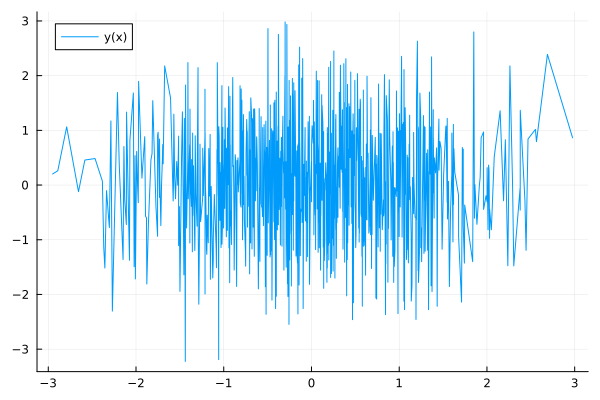

In [44]:
@df df plot(:x, :y, legend=:topleft, label="y(x)") # a most basic plot

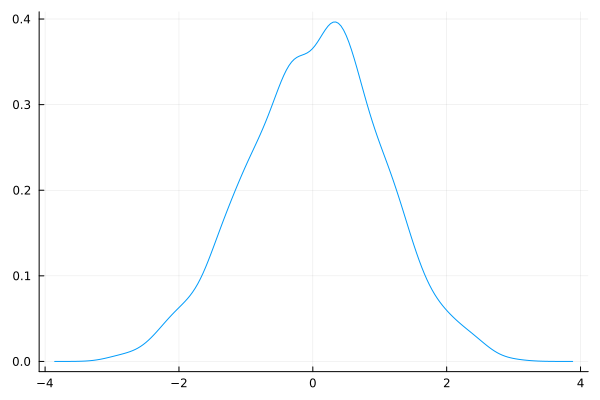

In [45]:
@df df density(:x, label="") # density plot

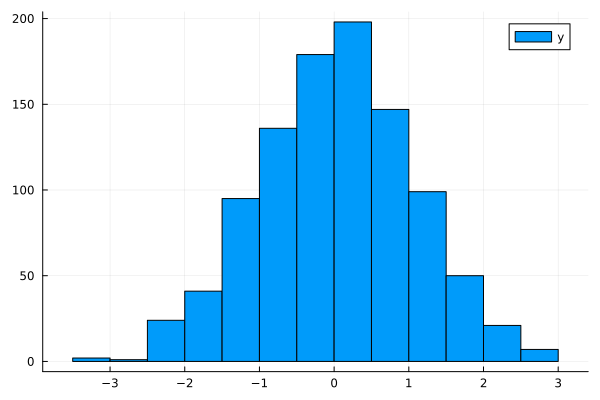

In [46]:
@df df histogram(:y, label="y") # and a histogram

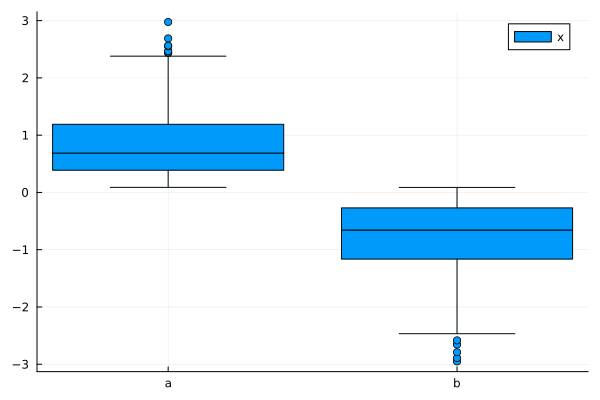

In [47]:
@df df boxplot(:z, :x, label="x") # the warning is likely to be removed in future releases of plotting packages

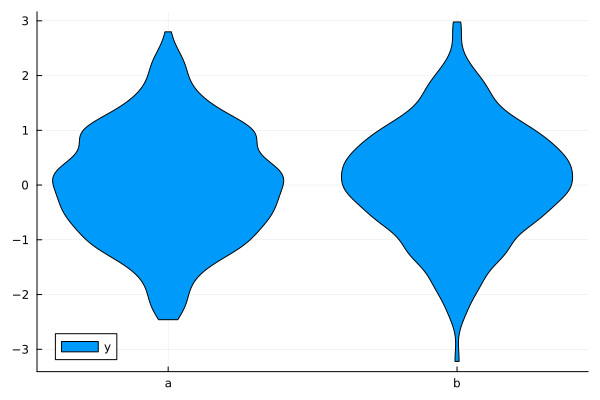

In [48]:
@df df violin(:z, :y, label="y") 